### Imports goes here

In [ ]:
#!conda install pandas-profiling --yes

In [4]:
bucket = 'sagemaker-demo1701'
prefix = 'ieee-fraud-detection'
import boto3 #python sdk
import re
import pandas as pd
#import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import os
import sagemaker
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score,roc_curve,precision_recall_curve,auc,average_precision_score
role = get_execution_role()
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
%matplotlib inline

### Load Data from S3 bucket

In [47]:
#load train and given data stored in s3
data_location = 's3://{}/{}'.format(bucket, prefix)
train_transaction = pd.read_csv(data_location + '/data/train_transaction.csv')
train_identity = pd.read_csv(data_location + '/data/train_identity.csv')
test_transaction = pd.read_csv(data_location + '/data/test_transaction.csv')
test_identity = pd.read_csv(data_location + '/data/test_identity.csv')

print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 394)
test_transaction shape is (506691, 393)
train_identity shape is (144233, 41)
test_identity shape is (141907, 41)


In [48]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique())))
print(np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique())))
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

144233
141907
Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [44]:
#delete dataframes 
del train_identity, train_transaction, test_identity, test_transaction

### EDA on given dataset

#Create pandas profile for train data sample and save as html
profile = pandas_profiling.ProfileReport(train.sample(frac=0.1),check_recoded = False)

rejected_variables = profile.get_rejected_variables(threshold=0.9)
profile.to_file(outputfile="output.html")
print ('Total {} variables has to be discarded as per the profiling results'.format(len(rejected_variables)))

In [6]:
#get missing value_information and add to drop_columns_list
cols_to_drop = []
missing_val = train.isnull().sum().sort_values(ascending = False)/train.shape[0]
cols_to_drop.extend(missing_val[missing_val >= 0.99].index.tolist())

#### Identify highly correlated features

In [7]:
# Create correlation matrix
corr_matrix = train.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [12]:
# Find index of feature columns with correlation greater than 0.95
high_corr_cols = [column for column in upper.columns if any(upper[column] > 0.9)]
high_corr_cols.remove('TransactionDT')
cols_to_drop.extend(high_corr_cols)

We will drop the identified columns before our further analysis.

In [49]:
train.drop(cols_to_drop,axis=1,inplace = True)
test.drop(cols_to_drop,axis=1, inplace = True)

In [50]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 230 columns.
Test dataset has 506691 rows and 229 columns.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


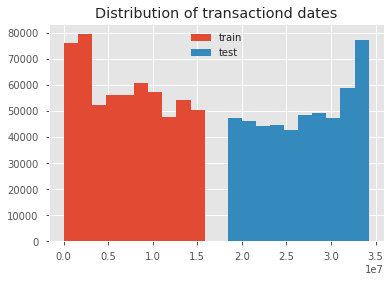

In [40]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');
plt.show()

In [51]:
#identify categorical columns
print(train.dtypes.value_counts())
cat_cols = train.dtypes[train.dtypes == 'object'].index.tolist()

float64    197
object      29
int64        4
dtype: int64


In [52]:
#Encode categorical features
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values)) 

In [53]:
print(train.dtypes.value_counts())

float64    197
int64       33
dtype: int64


In [57]:
#prepare train and test data for xgb 
data = train.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1).drop_duplicates()
data = pd.concat([data['isFraud'], data.drop(['isFraud'], axis=1)], axis=1)
xgb_train, xgb_validation = np.split(data, [int(0.7 * data.shape[0])]) 
X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
test = test[["TransactionDT", 'TransactionID']]
xgb_train.to_csv('xgb_train.csv', header=False, index=False)
xgb_validation.to_csv('xgb_validation.csv', header=False, index=False)

In [58]:

#we'll create s3_inputs that our training function can use as a pointer to the files in S3.
s3_input_train = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/xgb_train.csv')).upload_file('xgb_train.csv')
s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/xgb_validation.csv')).upload_file('xgb_validation.csv')

### Train an xgboost model

In [62]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [72]:

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(eta=0.1,
                        objective='binary:logistic',
                        eval_metric = 'auc',
                        num_round=500)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-07-24 09:48:27 Starting - Starting the training job...
2019-07-24 09:48:31 Starting - Launching requested ML instances......
2019-07-24 09:49:32 Starting - Preparing the instances for training...
2019-07-24 09:50:23 Downloading - Downloading input data...
2019-07-24 09:50:48 Training - Downloading the training image..
Arguments: train
[2019-07-24:09:51:07:INFO] Running standalone xgboost training.
[2019-07-24:09:51:07:INFO] File size need to be processed in the node: 364.25mb. Available memory size in the node: 8455.94mb
[2019-07-24:09:51:07:INFO] Determined delimiter of CSV input is ','
[09:51:07] S3DistributionType set as FullyReplicated
[09:51:09] 413027x227 matrix with 93757129 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-07-24:09:51:09:INFO] Determined delimiter of CSV input is ','
[09:51:09] S3DistributionType set as FullyReplicated
[09:51:10] 177012x227 matrix with 40181724 entries loaded from /opt/ml/input/data/validation?format=

In [73]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------!

In [83]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')
predictions = predict(X_test.as_matrix())

In [89]:
test['isFraud'] = predictions

In [91]:
test[['TransactionID','isFraud']].to_csv('submission.csv',index = False)

In [92]:
xgb_predictor.delete_endpoint()

In [93]:
xgb_predictor.delete_model()

### Reload the trained model

In [ ]:
model_job_name = 'xgboost-2019-07-24-09-48-26-999'
reloaded_xgb_model = sagemaker.estimator.Estimator.attach(model_job_name)

In [5]:
xgb_predictor = reloaded_xgb_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------------------------------------------------------------------------------------------------------!

In [6]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')
predictions = predict(X_test.as_matrix())

NameError: name 'X_test' is not defined

In [7]:
xgb_predictor.delete_endpoint()